## 두칸짜리 그리드 월드의 반복적 정책 평가 알고리즘

In [2]:
V = {'L1':0, 'L2':0}
cnt = 0
while True:
    t = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2']) # 첫 상태 공간의 가치함수
    delta = abs(t - V['L1']) # 첫 상태 공간의 가치함수 갱신값
    V['L1'] = t
    
    t = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2']) # 두번째 상태 공간의 가치함수
    delta = max(delta , abs(t - V['L2'])) # 첫 상태 공간의 가치함수 갱신값과 두번째 상태 공간의 갱신값 중 큰값
    V['L2'] = t
    
    cnt += 1
    if delta < 0.0001: # 가치함수 갱신값의 임계값보다 작다면
        print(V)
        print(f'갱신횟수 {cnt}회')
        break

{'L1': -2.2493782177156936, 'L2': -2.7494201578106514}
갱신횟수 60회


## Gridworld 생성
시각화 파일인 gridworld_render.py파일을 가져와서 사용한다. 시각화쪽은 코드가 복잡하여 이미 제작 되어 있는 형태를 사용한다.

In [2]:
import numpy as np
import gridworld_render as render_helper

class GridWorld:
    
    def __init__(self):
        self.action_space = [0, 1, 2, 3] # action index
        
        self.action_meaning = {0:'업', 
                               1:'다운',
                               2:'왼쪽',
                               3:'오른쪽'
        } # name of action
        
        self.reward_map = np.array(
        [[0, 0, 0, 1],
         [0, None, 0, -1],
         [0, 0, 0, 0]]
        ) # reward in space
        
        self.goal_state = (0, 3) # 목표
        self.wall_state = (1, 1) # 벽 좌표
        self.start_state = (2, 0) # 시작 좌표
        self.agent_state = self.start_state # 에이전트 초기 좌표
        
    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape
    
    def actions(self):
        return self.action_space
    
    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)
                
    def next_state(self, state, action):
        # 이동위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)] # 업, 다운, 왼쪽, 오른쪽을 행렬 인덱스에서 표현
        move = action_move_map[action] # 액션 인덱스에 따라 움직임 설정
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state
        
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state
        
        return next_state
    
    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)

In [3]:
env = GridWorld()

In [21]:
env = GridWorld()
print(env.height, env.width, env.shape)

for state in env.states():
    print(state)

3 4 (3, 4)
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)


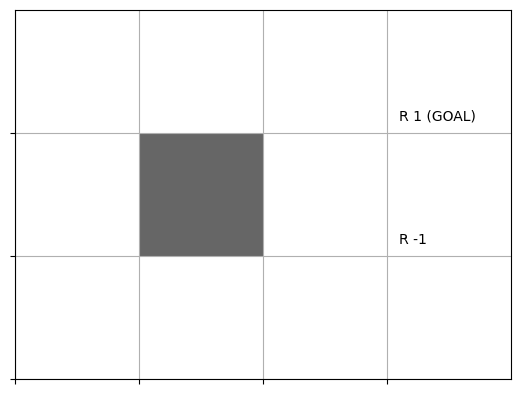

In [22]:
env.render_v()

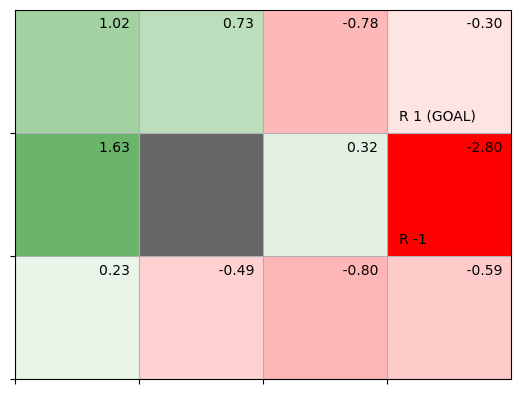

In [24]:
V = {}
for state in env.states():
    V[state] = np.random.randn()
env.render_v(V)

## 무작위 정책을 갖는 정책 평가 구현 (다만 정책을 한번만 평가한다.)

In [7]:
from collections import defaultdict
V = defaultdict(lambda: 0) # 상태 가치 딕셔너리
pi = defaultdict(lambda: {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}) # 무작위 정책 딕셔너리 위, 아래, 좌, 우

In [20]:
def eval_onestep(pi, V, env, gamma=0.9):
    """
    state를 순환하면서 정책에 따른 가치함수 업데이트 한번만 수행
    """
    for state in env.states():
        if state == env.goal_state: # 목표 도달 시의 가치는 0으로 설정
            V[state] = 0
            continue
        
        action_probs = pi[state] # 모든 상태에 따른 액션확률값(정책)을 딕셔너리로 저장
        new_V = 0 # 업데이트 될 상태가치 정의
        
        for action, action_probs in action_probs.items(): # state에 설정 된 정책(모든액션) 확률값 순환
            next_state = env.next_state(state, action) # state / action 전달받아 next state 설정
            r = env.reward(state, action, next_state) # reward map의 next_state를 인덱스로 받아 reward 설정
            new_V += action_probs * (r + gamma * V[next_state]) # 가치 업데이트
            
        V[state] = new_V
    return V

In [9]:
def policy_eval(pi, V, env, gamma=0.9, threshold=0.001):
    """
    eval_onestep을 지속적으로 수행하면서 업데이트 되는 가치의 값이 0.001 이하라면 정책 평가 종료
    """
    while True:
        old_V = V.copy()
        V = eval_onestep(pi, V, env, gamma)
        
        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t
        if delta < threshold:
            break
    return V

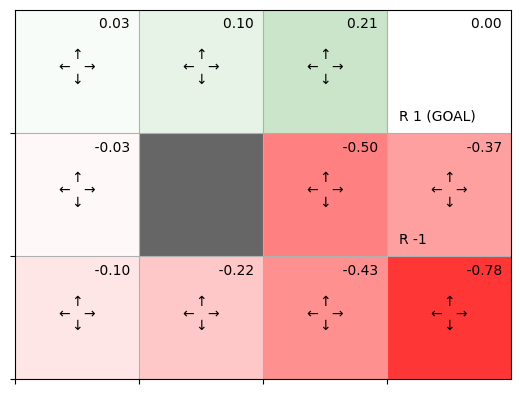

In [21]:
env = GridWorld()
gamma = 0.9
pi = defaultdict(lambda: {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25})
V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

## 정책 반복법

In [12]:
# 벨만 최적 방정식 중 최적결과를 찾는 argmax() 함수 구현
# 기본적으로는 최대값을 갖는 인덱스를 리턴하는 numpy argmax와 같다. 다만 딕셔너리에 적용되게 구현
def argmax(x):
    max_value = max(x.values()) # 최대값을 비교하면서 업데이트 하는 것이 아닌 최대값을 우선 설정 가능
    max_index = None
    for key, val in x.items(): # 최대값이 같더라고 마지막 키 리턴
        if val == max_value:
            max_index = key
    return max_index

In [16]:
# greedy 가치함수 평가
def greedy_policy(V, evn, gamma):
    """
    탐욕적 가치함수 평가도 기존 방법과 동일하게 onestep만 진행
    """
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state) # r(s, a, s')
            value = r + gamma * V[next_state] # v = rV(s')
            action_values[action] = value
        
        max_action = argmax(action_values) # 한 state에서의 모든 액션에 대한 value값 계산 후 가장 값이 높은 인덱스 반환
        action_probs = {0:0, 1:0, 2:0, 3:0}
        action_probs[max_action] = 1.0 # 가장 갚이 높은 액션의 확률값을 1로 설정
        pi[state] = action_probs # 정책 업데이트
    
    return pi

In [17]:
# 위 greedy 가치 업데이트 평가 반복
def policy_iter(env, gamma, threshold=0.001, is_render=False):
    pi = defaultdict(lambda : {0:0.25, 1:0.25, 2:0.25, 3:0.25})
    V = defaultdict(lambda : 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold)
        new_pi = greedy_policy(V, env, gamma)

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi:
            break
        pi = new_pi
    
    return pi

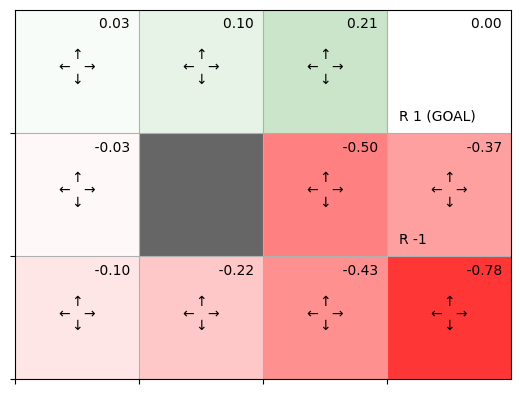

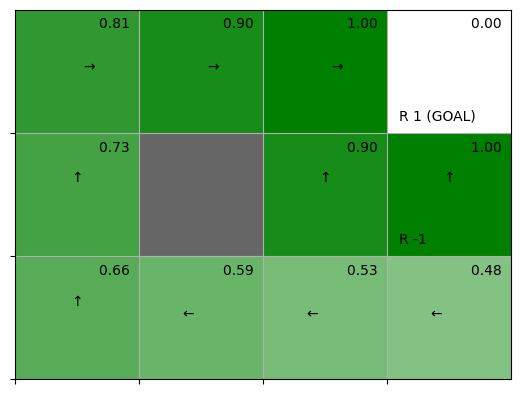

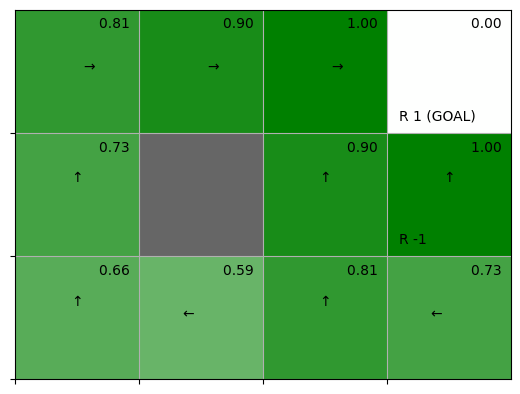

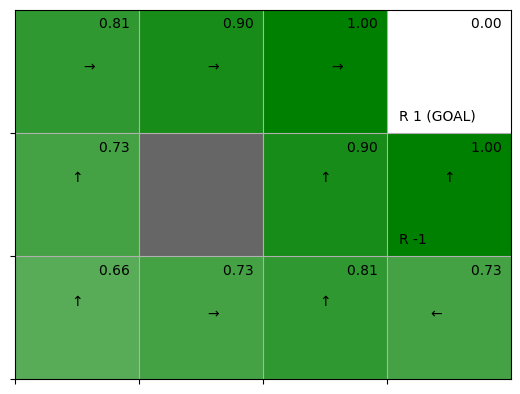

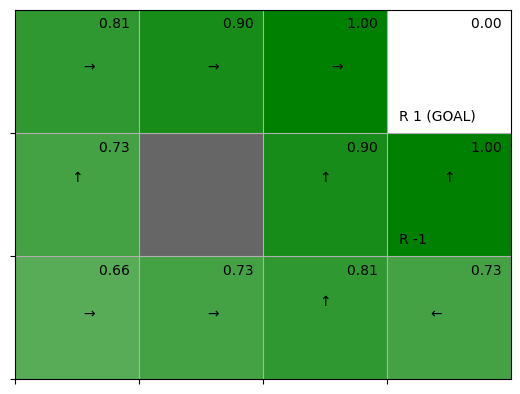

In [22]:
env = GridWorld()
gamma = 0.9
pi = policy_iter(env, gamma, is_render=True)